In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import load, dump
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/processed/clean_churn.csv")

os.makedirs("app/static/plots", exist_ok=True)
os.makedirs("reports", exist_ok=True)

model = load("models/churn_model.pkl")


Logistic Regression model not found. Retraining...


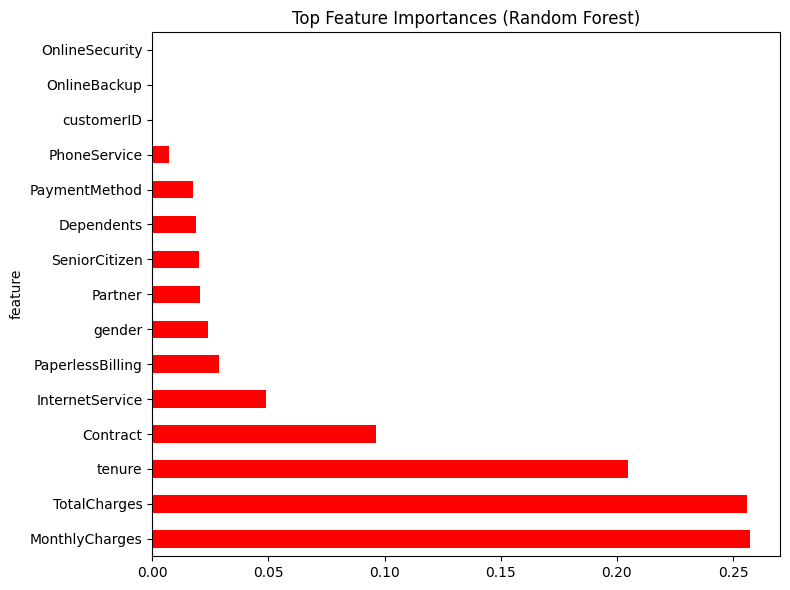

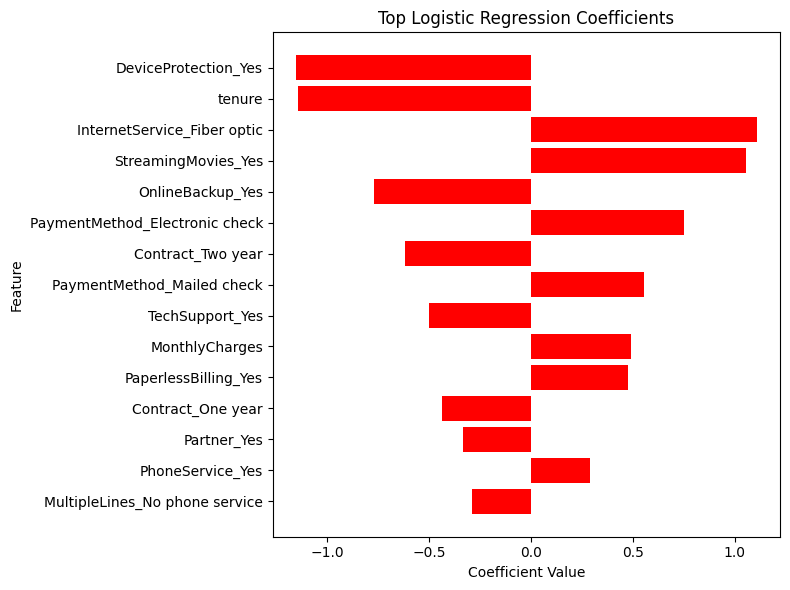

In [2]:


PLOTS_DIR = "app/static/plots/"
os.makedirs(PLOTS_DIR, exist_ok=True)

X = df.drop(columns=["Churn", "customerID"], errors="ignore")  
y = df["Churn"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = load("models/churn_model.pkl")

try:
    lr_model = load("models/lr_model.pkl")
    print("Logistic Regression model loaded.")
except FileNotFoundError:
    print("Logistic Regression model not found. Retraining...")
    lr_model = LogisticRegression(max_iter=2000)
    lr_model.fit(X_train_scaled, y_train)
    dump(lr_model, "models/lr_model.pkl")

features_rf = rf_model.feature_names_in_ if hasattr(rf_model, "feature_names_in_") else X.columns
importances = rf_model.feature_importances_

imp_rf = pd.DataFrame({"feature": features_rf, "importance": importances})
imp_rf = imp_rf.sort_values("importance", ascending=False).head(15)

imp_rf.plot(kind="barh", x="feature", y="importance", legend=False, color="red", figsize=(8,6))
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig(PLOTS_DIR + "feature_importance.png")
plt.show()

features_lr = lr_model.feature_names_in_ if hasattr(lr_model, "feature_names_in_") else X.columns
coef = lr_model.coef_[0]

imp_lr = pd.DataFrame({"feature": features_lr, "coefficient": coef})
imp_lr["abs_coef"] = imp_lr["coefficient"].abs()
imp_lr = imp_lr.sort_values("abs_coef", ascending=False).head(15)

plt.figure(figsize=(8,6))
plt.barh(imp_lr["feature"], imp_lr["coefficient"], color="red")
plt.title("Top Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(PLOTS_DIR + "feature_coefficients.png")
plt.show()


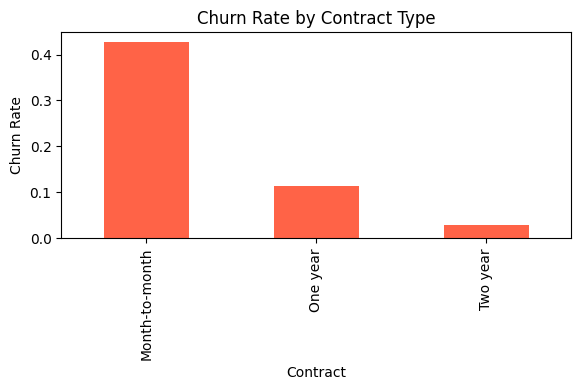

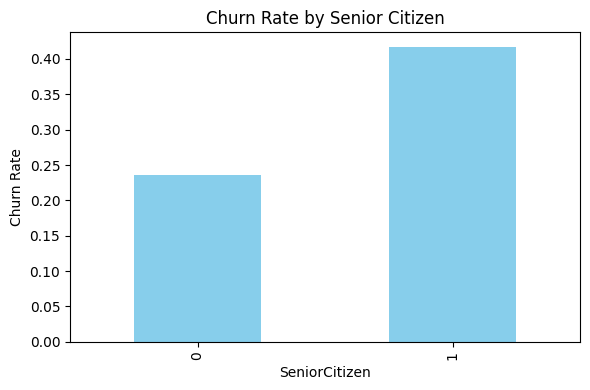

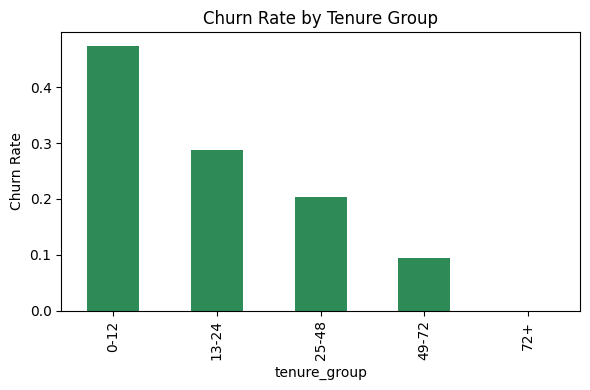

In [3]:
if df["Churn"].dtype == "object":
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Churn by Contract
if "Contract" in df.columns:
    contract_churn = df.groupby("Contract")["Churn"].mean()
    contract_churn.plot(kind="bar", color="tomato", figsize=(6,4))
    plt.title("Churn Rate by Contract Type")
    plt.ylabel("Churn Rate")
    plt.tight_layout()
    plt.savefig("app/static/plots/churn_by_contract.png")
    plt.show()

# Churn by Senior Citizen
if "SeniorCitizen" in df.columns:
    senior_churn = df.groupby("SeniorCitizen")["Churn"].mean()
    senior_churn.plot(kind="bar", color="skyblue", figsize=(6,4))
    plt.title("Churn Rate by Senior Citizen")
    plt.ylabel("Churn Rate")
    plt.tight_layout()
    plt.savefig("app/static/plots/churn_by_senior.png")
    plt.show()

# Churn by Tenure Group
if "tenure" in df.columns:
    df["tenure_group"] = pd.cut(
        df["tenure"],
        bins=[-1, 12, 24, 48, 72, 999],
        labels=["0-12", "13-24", "25-48", "49-72", "72+"]
    )
    tenure_churn = df.groupby("tenure_group", observed=False)["Churn"].mean()
    tenure_churn.plot(kind="bar", color="seagreen", figsize=(6,4))
    plt.title("Churn Rate by Tenure Group")
    plt.ylabel("Churn Rate")
    plt.tight_layout()
    plt.savefig("app/static/plots/churn_by_tenure.png")
    plt.show()


In [4]:
from joblib import load

rf_model = load("models/rf_model.pkl")
lr_model = load("models/lr_model.pkl")


FileNotFoundError: [Errno 2] No such file or directory: 'models/rf_model.pkl'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load data
df = pd.read_csv('data/processed/clean_churn.csv')

# Fix TotalCharges
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Split features/target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Encode categorical
X = pd.get_dummies(X, drop_first=True)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Scale numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Train models
lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


In [ ]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- Logistic Regression Performance ---
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

# --- Random Forest Performance ---
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

# --- Feature Importances (Random Forest) ---
imp_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_rf = imp_rf.head(5).to_string(index=False)

# --- Logistic Regression Coefficients ---
imp_lr = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "coefficient": lr.coef_[0]
})
imp_lr["abs_coef"] = imp_lr["coefficient"].abs()
imp_lr = imp_lr.sort_values("abs_coef", ascending=False)
top_lr = imp_lr.head(5).drop(columns="abs_coef").to_string(index=False)

# --- Build Report ---
report_lines = [
    "# Churn Insights Report\n",
    "\n",
    "## Model Performance (Test Set)\n",
    "### Logistic Regression\n",
    f"- Accuracy: {acc_lr:.2f}\n",
    f"- Precision: {prec_lr:.2f}\n",
    f"- Recall: {recall_lr:.2f}\n",
    f"- F1 Score: {f1_lr:.2f}\n",
    f"- ROC-AUC: {roc_auc_lr:.2f}\n\n",
    "### Random Forest\n",
    f"- Accuracy: {acc_rf:.2f}\n",
    f"- Precision: {prec_rf:.2f}\n",
    f"- Recall: {recall_rf:.2f}\n",
    f"- F1 Score: {f1_rf:.2f}\n",
    f"- ROC-AUC: {roc_auc_rf:.2f}\n\n",
    "## Top 5 Random Forest Features\n",
    f"{top_rf}\n\n",
    "## Top 5 Logistic Regression Coefficients\n",
    f"{top_lr}\n\n",
    "## Segmented Churn Rates\n",
    "- Contract: Higher churn in month-to-month contracts.\n",
    "- Senior Citizen: Higher churn among senior citizens.\n",
    "- Tenure: Customers with shorter tenure churn more.\n",
    "\n",
    "See plots in `app/static/plots/`.\n"
]

# Save report
os.makedirs("reports", exist_ok=True)
with open("reports/insights.md", "w") as f:
    f.write("".join(report_lines))

print("✅ Enhanced report saved to reports/insight.md")
